In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import SimpleITK as sitk
from pathlib import Path
from scipy import ndimage, misc
import numpy as np

/Users/naimsassine/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
t2_train_table = pd.read_csv('E:/Memoire/ProstateX/generated/train/dataframes/training_meta_data.csv')
t2_significant_findings = t2_train_table[t2_train_table.ClinSig == True]

In [4]:
t2 = t2_train_table.iloc[5]
adc = t2_train_table.iloc[100]
bval = t2_train_table.iloc[192]
ktrans = t2_train_table.iloc[287]

t2_image = sitk.ReadImage(str(t2['resampled_nifti']))
adc_image = sitk.ReadImage(str(adc['resampled_nifti']))
bval_image = sitk.ReadImage(str(bval['resampled_nifti']))
ktrans_image = sitk.ReadImage(str(ktrans['resampled_nifti']))

t2_case_array = sitk.GetArrayViewFromImage(t2_image)
adc_case_array = sitk.GetArrayViewFromImage(adc_image)
bval_case_array = sitk.GetArrayViewFromImage(bval_image)
ktrans_case_array = sitk.GetArrayViewFromImage(ktrans_image)

In [5]:
pos = t2['pos']
pos_1 = pos[1:-1]
converted_pos = pos_1.split(",")
pos = [float(i) for i in converted_pos]

t2_cancer_loc = t2_image.TransformPhysicalPointToIndex(pos)
adc_cancer_loc = adc_image.TransformPhysicalPointToIndex(pos)
bval_cancer_loc = bval_image.TransformPhysicalPointToIndex(pos)
ktrans_cancer_loc = ktrans_image.TransformPhysicalPointToIndex(pos)

In [6]:
def draw_image_wloc(array, voxel) : 
    x = voxel[0]
    y = voxel[1]
    z = voxel[2]
    fig,ax = plt.subplots(1)
    ax.imshow(array[z,:,:], cmap = 'gray') 
    rect = patches.Rectangle((x-15,y-15),30,30,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.show()

In [7]:
# Here I have a big missing step that I need raymond to help me with to make sure the localisation of the cancer is correct
# maybe hallayta for the t2, but for the rest???

In [8]:
t2_intensity = t2_case_array[t2_cancer_loc[2], t2_cancer_loc[1], t2_cancer_loc[0]]
adc_intensity = adc_case_array[adc_cancer_loc[2], adc_cancer_loc[1], adc_cancer_loc[0]]
bval_intensity = bval_case_array[bval_cancer_loc[2], bval_cancer_loc[1], bval_cancer_loc[0]]
ktrans_intensity = ktrans_case_array[ktrans_cancer_loc[2], ktrans_cancer_loc[1], ktrans_cancer_loc[0]]

In [50]:
t2_prewitt = ndimage.prewitt(t2_case_array[t2_cancer_loc[2]])[t2_cancer_loc[1]][t2_cancer_loc[0]]
adc_prewitt = ndimage.prewitt(adc_case_array[adc_cancer_loc[2]])[adc_cancer_loc[1]][adc_cancer_loc[0]]
bval_prewitt = ndimage.prewitt(t2_case_array[bval_cancer_loc[2]])[bval_cancer_loc[1]][bval_cancer_loc[0]]
ktrans_prewitt = ndimage.prewitt(ktrans_case_array[ktrans_cancer_loc[2]])[ktrans_cancer_loc[1]][ktrans_cancer_loc[0]]

In [52]:
t2_sobel = ndimage.sobel(t2_case_array[t2_cancer_loc[2]])[t2_cancer_loc[1]][t2_cancer_loc[0]]
adc_sobel = ndimage.sobel(adc_case_array[adc_cancer_loc[2]])[adc_cancer_loc[1]][adc_cancer_loc[0]]
bval_sobel = ndimage.sobel(t2_case_array[bval_cancer_loc[2]])[bval_cancer_loc[1]][bval_cancer_loc[0]]
ktrans_sobel = ndimage.sobel(ktrans_case_array[ktrans_cancer_loc[2]])[ktrans_cancer_loc[1]][ktrans_cancer_loc[0]]

In [8]:
from skimage.filters import gabor_kernel

def power(image, kernel):
    # Normalize images for better comparison.
    image = (image - image.mean()) / image.std()
    return np.sqrt(ndimage.convolve(image, np.real(kernel), mode='wrap')**2 +
                   ndimage.convolve(image, np.imag(kernel), mode='wrap')**2)

images = [t2_case_array[t2_cancer_loc[2]]]
# Plot a selection of the filter bank kernels and their responses.
results = []
kernel_params = []
for theta in (0, 1):
    theta = theta / 4. * np.pi
    for frequency in (0.1, 0.4):
        kernel = gabor_kernel(frequency, theta=theta)
        params = 'theta=%d,\nfrequency=%.2f' % (theta * 180 / np.pi, frequency)
        kernel_params.append(params)
        # Save kernel and the power image for each image
        results.append((kernel, [power(img, kernel) for img in images]))


t2_gabor_1 = results[0][1][0][t2_cancer_loc[1]][t2_cancer_loc[0]]
t2_gabor_2 = results[1][1][0][t2_cancer_loc[1]][t2_cancer_loc[0]]
t2_gabor_3 = results[2][1][0][t2_cancer_loc[1]][t2_cancer_loc[0]]
t2_gabor_4 = results[3][1][0][t2_cancer_loc[1]][t2_cancer_loc[0]]

In [9]:
# read code du type to extract mask from image and store it somewhere
def generate_patches(row):

    patch_sizes = {
        't2': 32,
        'adc': 8,
        'bval':8,
        'ktrans':8
    }
    path_to_resampled_file = row.resampled_nifti
    pos = row.pos
    pos_1 = pos[1:-1]
    converted_pos = pos_1.split(",")
    reported_pos = [float(i) for i in converted_pos]


    if 't2' in row.DCMSerDescr:
        patch_size = patch_sizes.get('t2')
    elif 'adc' in row.DCMSerDescr:
        patch_size = patch_sizes.get('adc')
    elif 'bval' in row.DCMSerDescr:
        patch_size = patch_sizes.get('bval')
    else:
        patch_size = patch_sizes.get('ktrans')


    def load_image(path_to_resampled_file):
        sitk_image = sitk.ReadImage(str(path_to_resampled_file))
        image_array = sitk.GetArrayViewFromImage(sitk_image)
        return sitk_image, image_array
    
    def calculate_location_of_finding(sitk_image, reported_pos):
        location_of_finding = sitk_image.TransformPhysicalPointToIndex(reported_pos)
        return location_of_finding
    
    def extract_patch(image_array, location_of_finding, patch_size):
        x = location_of_finding[0]
        y = location_of_finding[1]

        x_start = x - (patch_size // 2)
        x_end = x + (patch_size // 2)
        y_start = y - (patch_size // 2)
        y_end = y + (patch_size // 2)

        try:
            extracted_patch = image_array[location_of_finding[2], y_start:y_end, x_start:x_end]
        except IndexError:
            extracted_patch = image_array[-1, x_start:x_end, y_start:y_end]
            problem_cases.append(row.ProxID)
            problem_cases.append(row.DCMSerDescr)
            print('Problem with image:', row.ProxID, path_to_resampled_file)
            pass 

        return extracted_patch


    sitk_image, image_array = load_image(path_to_resampled_file)
    location_of_finding = calculate_location_of_finding(sitk_image, reported_pos)
    
    
    patch = extract_patch(image_array, location_of_finding, patch_size)
    
    return patch

In [10]:
patch_t2 = generate_patches(t2)

In [11]:
patch_t2
generated_image = sitk.GetImageFromArray(patch_t2)

In [12]:
outputImageFileName = "E:/Memoire/ProstateX/generated/patches/test.nrrd"
writer = sitk.ImageFileWriter()
writer.SetFileName(outputImageFileName)
writer.Execute(generated_image)

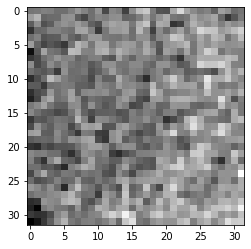

In [13]:
fig,ax = plt.subplots(1)
ax.imshow(patch_t2, cmap = 'gray') 
plt.show()

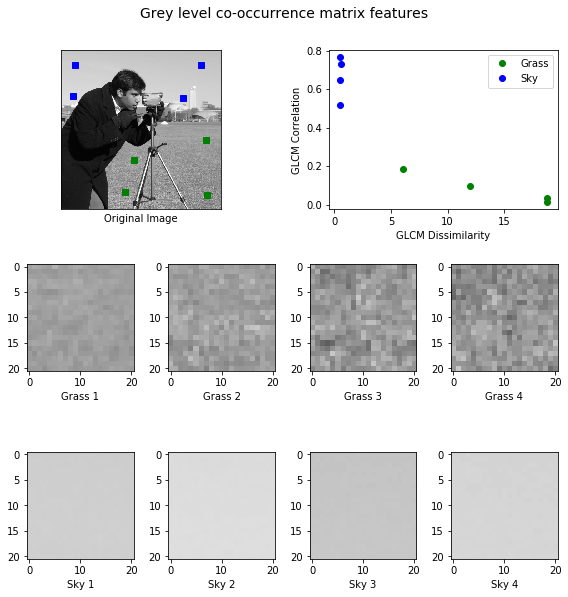

In [16]:
import matplotlib.pyplot as plt

from skimage.feature import greycomatrix, greycoprops
from skimage import data


PATCH_SIZE = 21

# open the camera image
image = data.camera()

# select some patches from grassy areas of the image
grass_locations = [(280, 454), (342, 223), (444, 192), (455, 455)]
grass_patches = []
for loc in grass_locations:
    grass_patches.append(image[loc[0]:loc[0] + PATCH_SIZE,
                               loc[1]:loc[1] + PATCH_SIZE])

# select some patches from sky areas of the image
sky_locations = [(38, 34), (139, 28), (37, 437), (145, 379)]
sky_patches = []
for loc in sky_locations:
    sky_patches.append(image[loc[0]:loc[0] + PATCH_SIZE,
                             loc[1]:loc[1] + PATCH_SIZE])

# compute some GLCM properties each patch
xs = []
ys = []
for patch in (grass_patches + sky_patches):
    glcm = greycomatrix(patch, distances=[5], angles=[0], levels=256,
                        symmetric=True, normed=True)
    xs.append(greycoprops(glcm, 'dissimilarity')[0, 0])
    ys.append(greycoprops(glcm, 'correlation')[0, 0])



In [ ]:
# Lopes et al. used fractal analysis and more precisely a local estimation of the fractal
# dimension [20], to describe the texture roughness at a specic location

In [ ]:
# Litjens et al. computed the texture map based on T2-W-MRI images using a Gaussian filter bank [163].